In [19]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from tslearn.utils import to_time_series_dataset
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, TimeSeriesScalerMinMax
from scipy.ndimage import gaussian_filter1d

In [2]:
print(np.__version__)

2.1.0


In [3]:
data_dir = "../data/processed/regional/"

In [4]:
# Helper Functions
def load_data(data_dir):
    all_files = [f for f in os.listdir(data_dir) if f.endswith(".csv")]
    city_data = {}

    for file in all_files:
        city_name = file.replace("_metro.csv", "")
        df = pd.read_csv(os.path.join(data_dir, file), parse_dates=["period_begin"])
        df = df[df["property_type"] == "Single Family Residential"]  # Focus on single-family homes
        city_data[city_name] = df
    return city_data

#Create time Lagged features from select features
def create_lagged_features(df, lags=3):
    for lag in range(1, lags + 1):
        df[f"median_sale_price_lag{lag}"] = df["median_sale_price"].shift(lag)
        df[f"inventory_lag{lag}"] = df["inventory"].shift(lag)
        df[f"sold_above_list_lag{lag}"] = df["sold_above_list"].shift(lag)
    return df.dropna()

In [5]:
city_data = load_data(data_dir)

all_data = []
time_series_yoy_data = []
time_series_data_raw = []
city_label = []
for city, df in city_data.items():
    df["city"] = city  # Keep track of city
    all_data.append(df)
    if df['median_sale_price'].notna().any():
        city_label.append(city)
        time_series_yoy_data.append(df['median_sale_price_yoy'])
        time_series_data_raw.append(df['median_sale_price'])

housing_df = pd.concat(all_data)
display(city_label)

['Aberdeen_SDmetroarea.csv',
 'Aberdeen_WAmetroarea.csv',
 'Abilene_TXmetroarea.csv',
 'Ada_OKmetroarea.csv',
 'Adrian_MImetroarea.csv',
 'Akron_OHmetroarea.csv',
 'Alamogordo_NMmetroarea.csv',
 'Albany_GAmetroarea.csv',
 'Albany_NYmetroarea.csv',
 'Albany_ORmetroarea.csv',
 'Albemarle_NCmetroarea.csv',
 'AlbertLea_MNmetroarea.csv',
 'Albertville_ALmetroarea.csv',
 'AlexanderCity_ALmetroarea.csv',
 'Alexandria_LAmetroarea.csv',
 'Alexandria_MNmetroarea.csv',
 'Alice_TXmetroarea.csv',
 'Allentown_PAmetroarea.csv',
 'Alma_MImetroarea.csv',
 'Alpena_MImetroarea.csv',
 'Altoona_PAmetroarea.csv',
 'Altus_OKmetroarea.csv',
 'Amarillo_TXmetroarea.csv',
 'Americus_GAmetroarea.csv',
 'Ames_IAmetroarea.csv',
 'Amsterdam_NYmetroarea.csv',
 'Anaheim_CAmetroarea.csv',
 'Anchorage_AKmetroarea.csv',
 'Andrews_TXmetroarea.csv',
 'Angola_INmetroarea.csv',
 'AnnArbor_MImetroarea.csv',
 'Anniston_ALmetroarea.csv',
 'Appleton_WImetroarea.csv',
 'Arcadia_FLmetroarea.csv',
 'Ardmore_OKmetroarea.csv',
 'Arka

In [6]:
time_series_yoy_dataset = to_time_series_dataset(time_series_yoy_data)
display(time_series_yoy_data)

[231   -0.250000
 232   -0.087302
 233    0.122200
 234    0.043478
 235    0.029796
          ...   
 384   -0.050559
 385   -0.005753
 386    0.118116
 387   -0.168605
 388    0.388140
 Name: median_sale_price_yoy, Length: 158, dtype: float64,
 444   -0.440179
 445   -0.002136
 446   -0.274802
 447   -0.008621
 448   -0.066511
          ...   
 597    0.062665
 598   -0.074550
 599    0.283333
 600   -0.029412
 601    0.056338
 Name: median_sale_price_yoy, Length: 158, dtype: float64,
 379   -0.088000
 380    0.154028
 381    0.011072
 382   -0.010620
 383   -0.027559
          ...   
 532    0.088043
 533    0.159133
 534    0.176744
 535   -0.057330
 536   -0.078846
 Name: median_sale_price_yoy, Length: 158, dtype: float64,
 136    7.888889
 137    7.888889
 138    7.888889
 139    7.888889
 140    7.888889
          ...   
 267   -0.312308
 268    0.184416
 269    0.067073
 270    0.258771
 271   -0.114286
 Name: median_sale_price_yoy, Length: 136, dtype: float64,
 453   -0.177484

In [7]:
scaler = TimeSeriesScalerMinMax()
time_series_dataset_scaled = scaler.fit_transform(time_series_yoy_dataset)

C:\Users\bhoen\OneDrive\Documents\Projects\PythonEnvironments\DataScivenv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\bhoen\OneDrive\Documents\Projects\PythonEnvironments\DataScivenv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


C:\Users\bhoen\OneDrive\Documents\Projects\PythonEnvironments\DataScivenv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\bhoen\OneDrive\Documents\Projects\PythonEnvironments\DataScivenv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\bhoen\OneDrive\Documents\Projects\PythonEnvironments\DataScivenv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\bhoen\OneDrive\Documents\Projects\PythonEnvironments\DataScivenv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\bho

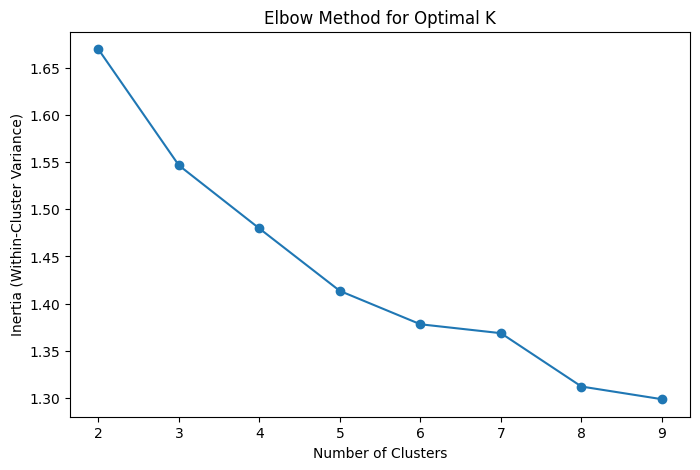

In [8]:
k_values = range(2, 10)  # Typically start at 2 and go up to 10 or more

# Store inertia values
inertia_values = []
label_df = pd.DataFrame()
label_df['city'] = city_label

for k in k_values:
    model = TimeSeriesKMeans(n_clusters=k, metric="dtw", random_state=0)
    labels = model.fit_predict(time_series_dataset_scaled)
    inertia_values.append(model.inertia_)
    label_df[f"{k}"] = labels
    
# Plot the elbow curve
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia_values, marker='o', linestyle='-')
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia (Within-Cluster Variance)")
plt.title("Elbow Method for Optimal K")
plt.show()

C:\Users\bhoen\OneDrive\Documents\Projects\PythonEnvironments\DataScivenv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\bhoen\OneDrive\Documents\Projects\PythonEnvironments\DataScivenv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


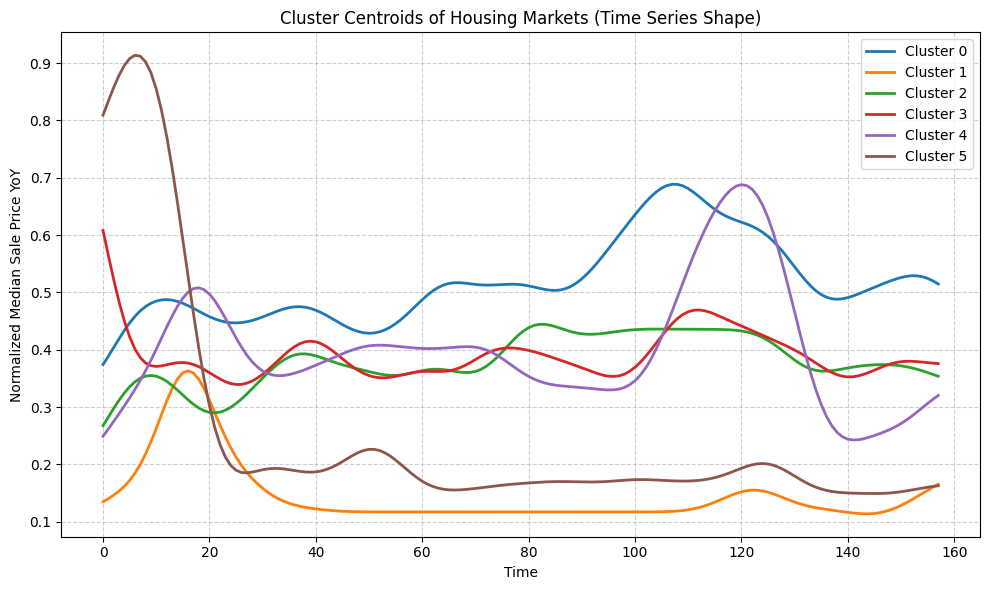

In [26]:
OptimalK = 6
model  = TimeSeriesKMeans(n_clusters=OptimalK, metric="dtw", random_state=0)
labels = model.fit_predict(time_series_dataset_scaled)

palette = sns.color_palette("tab10", OptimalK)
plt.figure(figsize=(10, 6))

for i in range(OptimalK):
    # barycentre has shape (T, 1); flatten to (T,)
    centroid = model.cluster_centers_[i].ravel()

    centroid_smooth = gaussian_filter1d(
        centroid,
        sigma=5,          # or something smaller!
        mode="nearest",
        truncate=4.0,
    )

    # if you don’t supply x, matplotlib uses the index automatically
    plt.plot(centroid_smooth, label=f"Cluster {i}", color=palette[i], lw=2)

plt.xlabel("Time")
plt.ylabel("Normalized Median Sale Price YoY")
plt.title("Cluster Centroids of Housing Markets (Time Series Shape)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


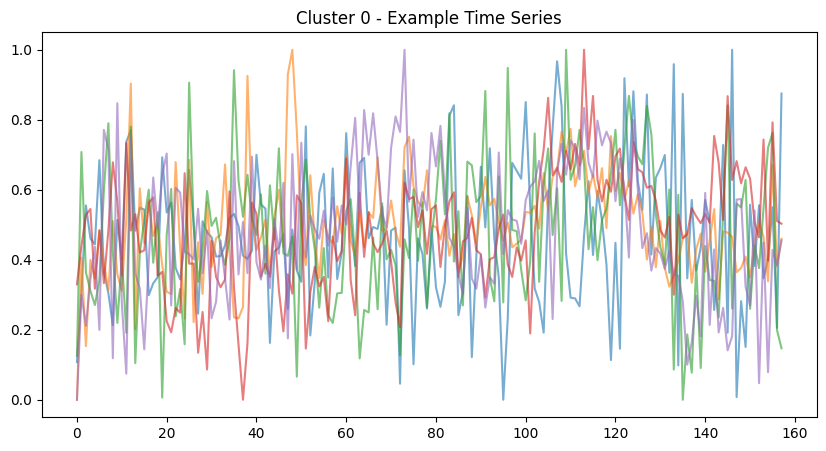

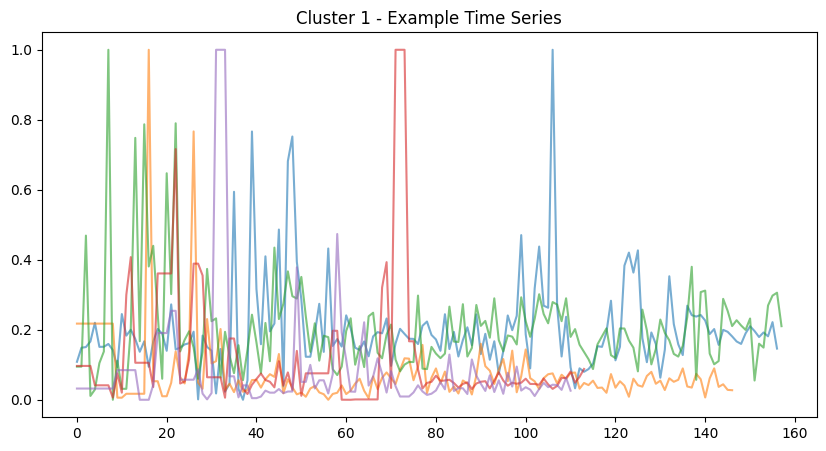

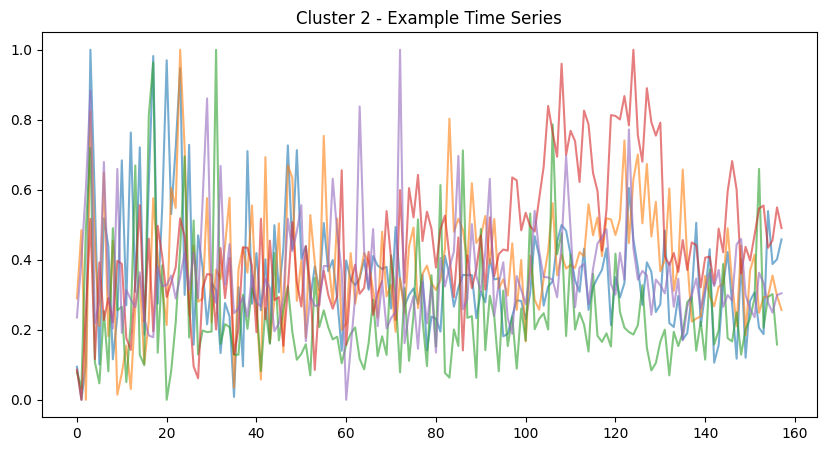

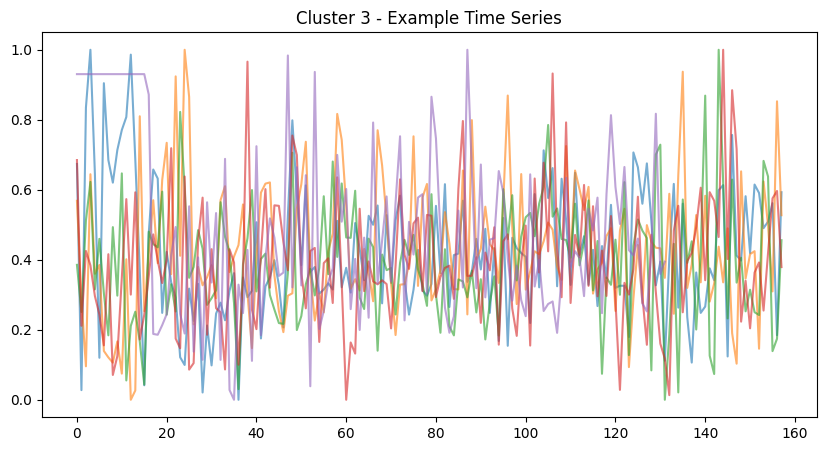

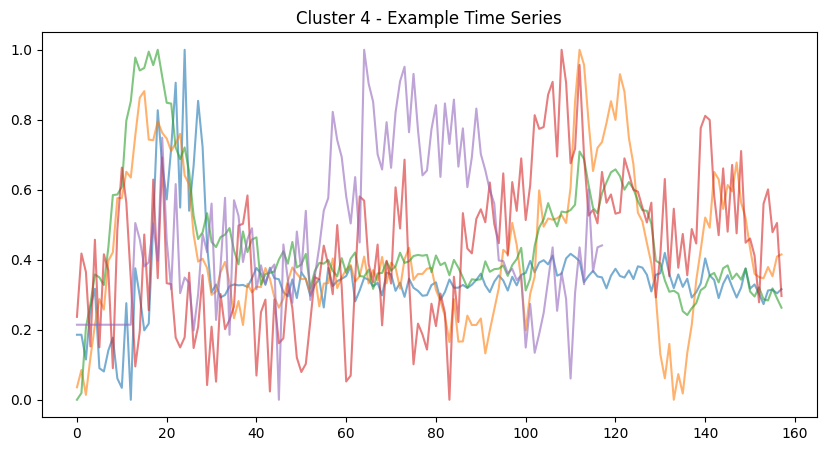

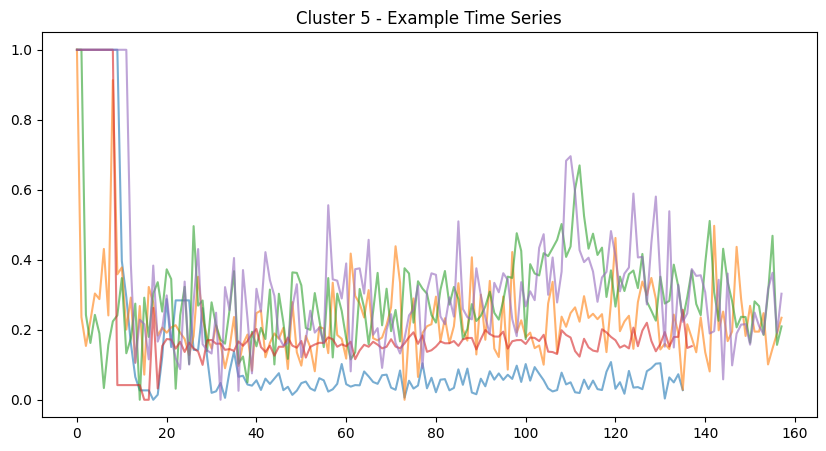

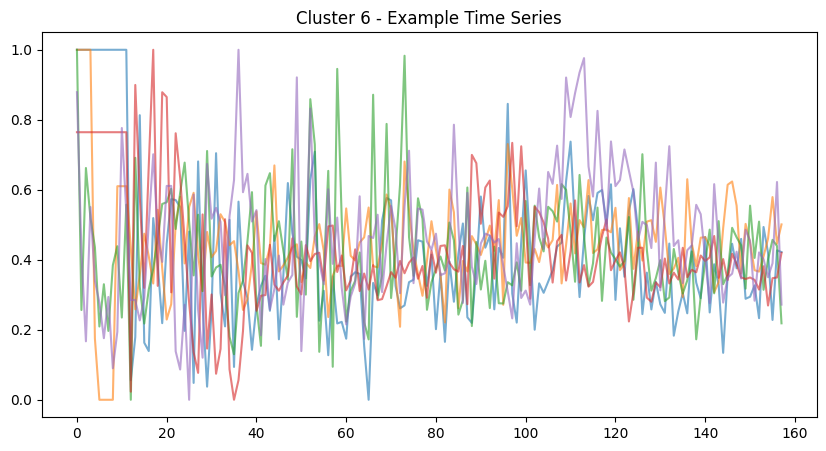

In [10]:
for i in range(OptimalK):  # Assuming 3 clusters
    plt.figure(figsize=(10, 5))
    for idx, series in enumerate(time_series_dataset_scaled[labels == i][:5,:]):  # First 5 series per cluster
        plt.plot(series, alpha=0.6)
    plt.title(f"Cluster {i} - Example Time Series")
    plt.show()

In [11]:
def format_single_filename(filename):
    base = filename.replace('_metroarea.csv', '').replace('metroarea.csv', '').replace('.csv', '')
    if '_' in base:
        parts = base.rsplit('_', 1)
        city = parts[0].replace('_', ' ')
        state = parts[1]
        return f"{city}, {state}"
    else:
        return base

label_df['city'] = label_df['city'].apply(format_single_filename)

In [12]:
display(label_df)

,city,2,3,4,5,6,7,8,9
0,"Aberdeen, SD",0,0,0,0,0,0,0,0
1,"Aberdeen, WA",0,0,0,0,0,0,0,8
2,"Abilene, TX",0,0,0,0,0,0,0,0
3,"Ada, OK",1,1,3,3,5,5,4,4
4,"Adrian, MI",0,2,2,2,2,2,3,3
...,...,...,...,...,...,...,...,...,...
894,"Youngstown, OH",0,2,2,2,2,2,3,3
895,"YubaCity, CA",0,2,2,4,4,4,2,2
896,"Yuma, AZ",1,1,1,1,1,1,6,6
897,"Zanesville, OH",0,2,2,2,2,2,3,3


In [13]:
label_df['city'] = city_label

In [14]:
location_df = pd.read_csv('C:\\Users\\bhoen\\Downloads\\locations.csv')

In [15]:
for k in k_values:
    df = location_df.copy()
    df.insert(1,'cluster',label_df[f"{k}"])
    df.to_csv(f"DTW_{k}.csv", index=False)
    